# Dip picking
- [Balthazar Neveu](https://www.linkedin.com/in/balthazarneveu/)
- TP-4 [Introduction to geosciences](https://www.master-mva.com/cours/introduction-a-lapprentissage-statistique-pour-les-geosciences/) | ENS Paris Saclay - [Master MVA](https://www.master-mva.com/) 2024
- [Web version](https://balthazarneveu.github.io/geosciences) | [Github](https://github.com/balthazarneveu/geoscience)

![](report/result.png)

# Outline

-------

### Introduction
- Overview of the results and conclusion
- instructions, proposed methodology

### Simulation
- PART 1: Simulation We'll first define planes
- PART 2: We'll then synthesize planes and work with vector data:
  - by sampling 3D and 2D corresponding points and their normals.
  - we'll validate the concept of plane parameters estimations from tangents.
- PART 3: We'll synthesize borehole images and validate image data processing
  - mimick projected planes, with the same units used in real images
  - extract 2D gradients and tangents
  - deduce 3D tangents
  - use randomized cross products to fit a plane.
### Real data
- PART 4 : Apply to real images
  - The main difference compared to the simulation stands in:
    -  gradient curation  (remove a few vertical gradients)
    -  in the choice of a region of interest (if  you pick a zone which is too big, you may get several planes and several trends)

--------

# Introduction
### Results overview / Conclusion
This work in short:
- ✅ Method developped and tested on simulations then applied to real images.
- ✅ Single line to process a section of the borehole. (see the next python cell which processes a section).
- ✅ A single [script `data_processing.py`](data_processing.py) to process hole borehole sections. 
- ⚠️ Far from being a fully automated tool


![](report/batch_over_slices.png)

- ⚠️  Known limitations 
  - Trend extraction requires picking the right window
  - 2 thresholds regarding gradient extractions, may require tuning or more automation by looking at histogram of gradient magnitudes.
  - Cannot retrieve each plane separately

> ⚠️ Fixing all details to improve robustness and get full automation would require a lot more engineering work out of the scope of a lab session.

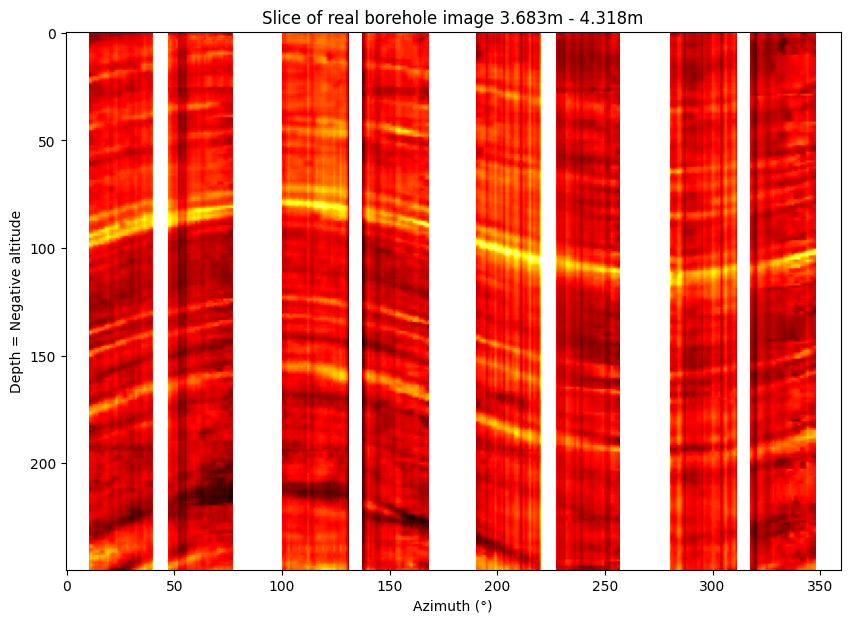

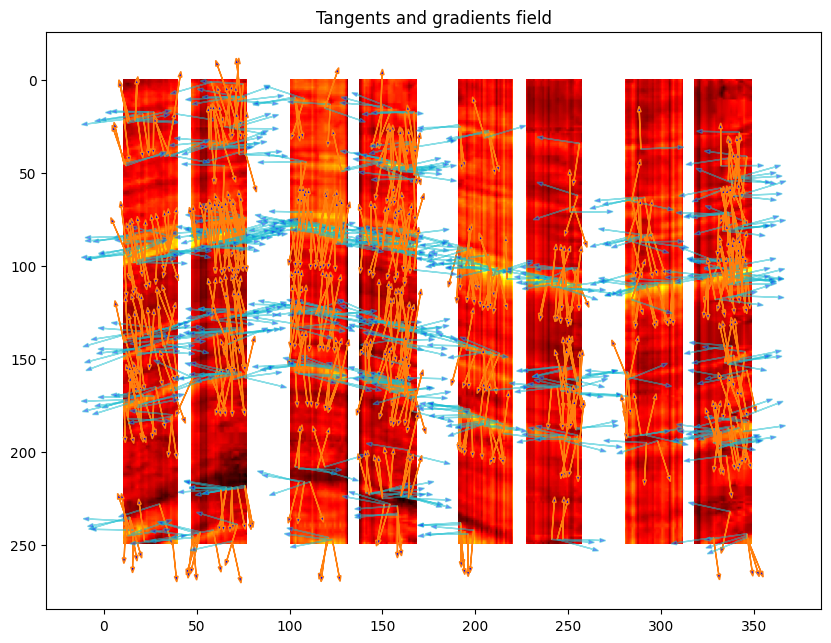

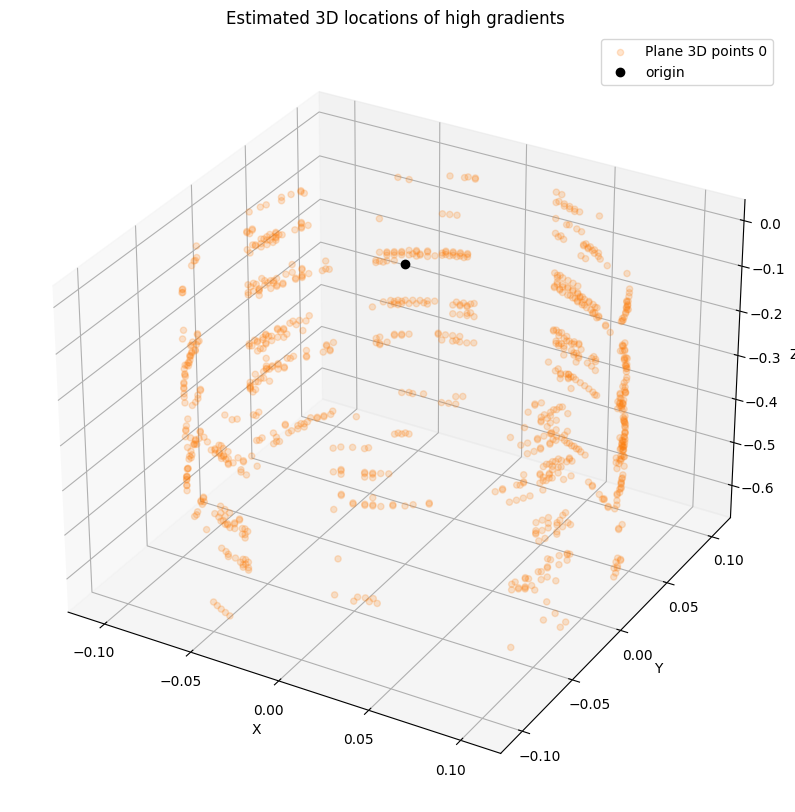

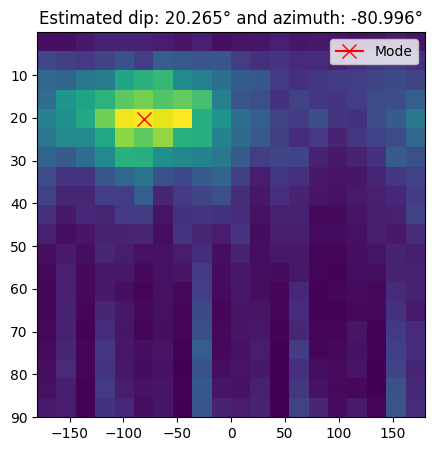

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


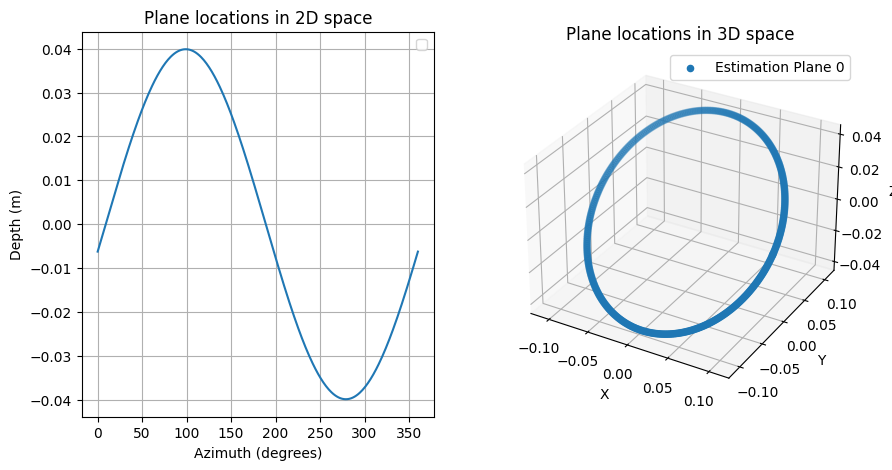

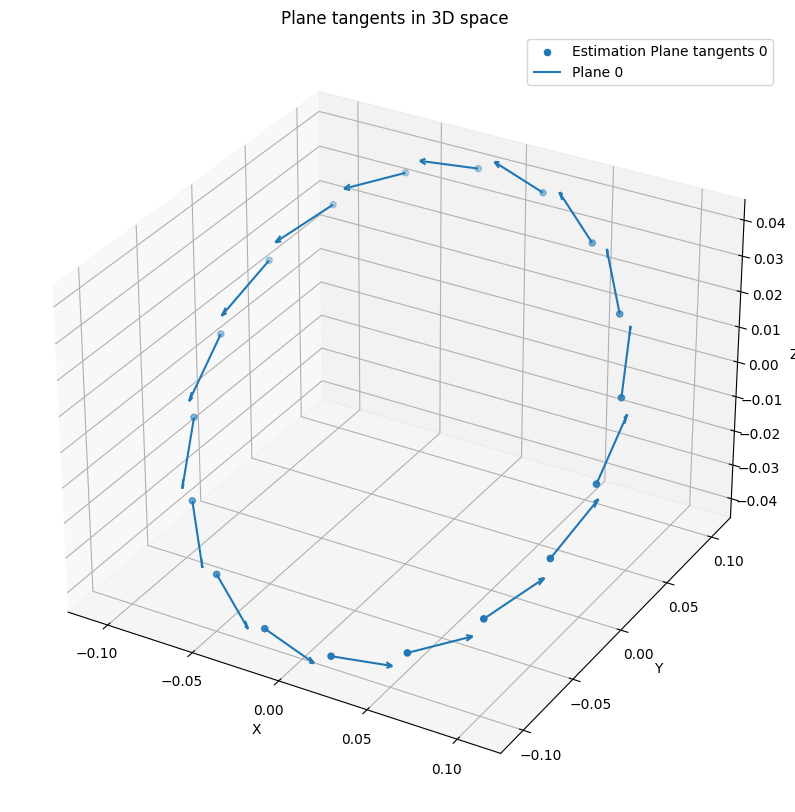

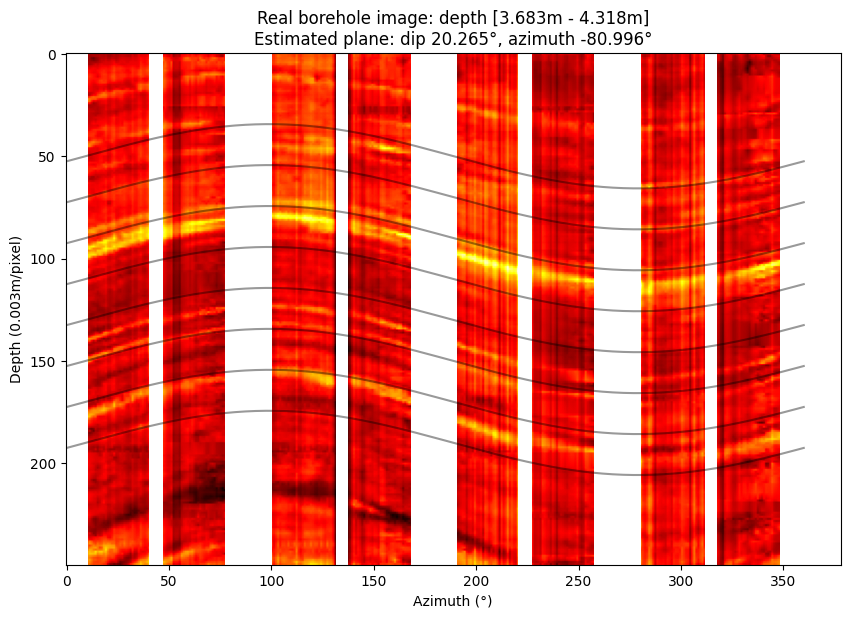

In [123]:
from data_processing import main as main_processing
main_processing(forced_roi=[1450, 1700], out_folder=None, debug=True)

# Preliminary: instructions and method


### INSTRUCTION: Sinusoid extraction: automated trend extraction
Implement randomized Hough transform:
- Compute gradient of image and associated vectors
- Display the vectors
- Pick randomly vectors and compute their vectorial product; store them in an accumulator
- Take the most probable vector
- Compute the associated angles
- Display the associated sinusoid
- DEPTH in feet, DIAMETER 8.5 inches

### Proposed approach to solve the problem
Here's the reasoning (and questions) I took to solve the problem.

#### Step A: solve the problem on synthetic data

1. Write 3D simulation and Forward = synthezis & Inverse = fit the plane methods:
- ✅ Normal definitions (unit tests)
- ✅ *Synthesis*: Simulate 3D vectors: compute tangent vector to the cylinder when they intersect with a plane
- ✅ *Inverse*: Perform method 1: Fit the plane first using the vector product by taking random samples.
- *Inverse*: Perform method 2: Formulation as an optimization problem
- ~~Curiosity question :Add a bit of noise, check sensitivity. Check sensitivity to noise and number of samples~~

2. Simulate imaging:
- ✅ *Synthesis*:Simulate 2D projection
- ✅ *Inverse*: Go backwards from 2D gradients to 3D gradients.


#### Step B: Apply to real images
- ✅ Work on windows.
- ✅ Extract gradients, remove vertical.
- ✅ Normalize unit correctly.
- ✅ Apply previous methods
- ✅ Batch over windows
- ~~*Curiosity question*: Are the vertical patterns annoying, if yes, we should almost use the method from TP3 (but it seems that the holes images have been resampled already (not straight!)?) Morphological operations may allow to remove these column patterns.~~



-------

In [2]:
from plane_cylinder_projections import *
from visualizations import (plot_ground_truth_3d, validation_of_3d_tangent_estimation, show_borehole_image,
                            show_gradients_magnitudes, plot_tangents_and_gradients_field, plot_3d_scatter, COLORS)
from simulations import DEFAULT_PLANE_ANGLES, create_planes_projection, simulated_splat_image, get_3d_tangent_estimation_using_groundtruth
from image_processing import extract_2d_gradients_from_image
from data_processing import load_data, extract_2d_gradients
from data_processing import main as main_processing
from constants import *
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters
from plane_extraction import get_cross_products
%load_ext autoreload
%autoreload 2


# PART 1: Plane definition
A plane is defined by its normal vector $\vec{p}$ and its altitude $z_0$ and also parameterized as 2 angles (dip $\delta$ and azimut $\alpha$)
| Plane and normal $\vec{p}$ | Plane normal vector dip $\delta$ , azimuth $\alpha$ |
| :--: |  :--: | 
|  ![](report/plane_normal_definition.png) | ![](report/normal_definition.png) |

- If $\delta=0$, horizontal slice ($alpha$ is not informative by the way), we'll get a line in the images
- If $\delta=90°$, vertical plane (corresponds to infinite amplitude oscillation = vertical line).

We'll define a set of planes by a tensor `[N, 3]` where `N` is the batch dimension/number of planes.
Parameters are expressed as 
```
[
    [dip1 (rad), azimuth1 (rad), altitude1 (m)],
    [dip2 (rad), azimuth2 (rad), altitude2 (m)]
]
``` 


In [124]:
# First, let's define some groundtruth planes (dip, azimut)
# Pick one among several configurations
mixed_slices = ["crazy", "parallel", "bisec_parallel_slight_noise", "parallel_slight_noise", "demo"][3]
if mixed_slices == "crazy":
    plane_angle = torch.tensor(
        [
            [0., 0.,  -0.3],
            [torch.pi/4, torch.pi/4, 0.],
            [0.8*torch.pi/2., torch.pi/4, -1.],
            [0.9*torch.pi/2., torch.pi/3, -0.5],
            [0.1, torch.pi/2, -1.2],
        ]
    )
elif mixed_slices == "parallel":
    plane_angle = torch.tensor(
        [
            [torch.pi/4, torch.pi/4, 0.],
            [torch.pi/4, torch.pi/4, -0.3],
            [torch.pi/4, torch.pi/4, -0.6],
            [torch.pi/4, torch.pi/4, -0.8],
        ]
    )
elif mixed_slices == "bisec_parallel_slight_noise":
    plane_angle = torch.tensor(
        [
            [0.99*torch.pi/4, torch.pi/4, -0.2],
            [torch.pi/4, 0.99*torch.pi/4, -0.3],
            [1.02*torch.pi/4, torch.pi/4, -0.6],
            [torch.pi/4, 1.01*torch.pi/4, -0.8],
        ]
    )
elif mixed_slices == "parallel_slight_noise":
    plane_angle = torch.tensor(
        [
            [0.99*torch.pi/4, 1.4*torch.pi/4, -0.2],
            [torch.pi/4, 0.99*1.4*torch.pi/4, -0.3],
            [1.02*torch.pi/4, 1.4*torch.pi/4, -0.6],
            [torch.pi/4, 1.01*1.4*torch.pi/4, -0.8],
        ]
    )
elif mixed_slices == "demo":
    plane_angle = torch.tensor(
    [
        [0.0, 0., -0.1],
        [0.1, 0., -0.3],
        [0.1, 0.5, -0.4],
        [0.3, 0., -0.5],
        [0.5, 0., -0.7],
        [0.5, -0.5, -0.8],
    ]
    )

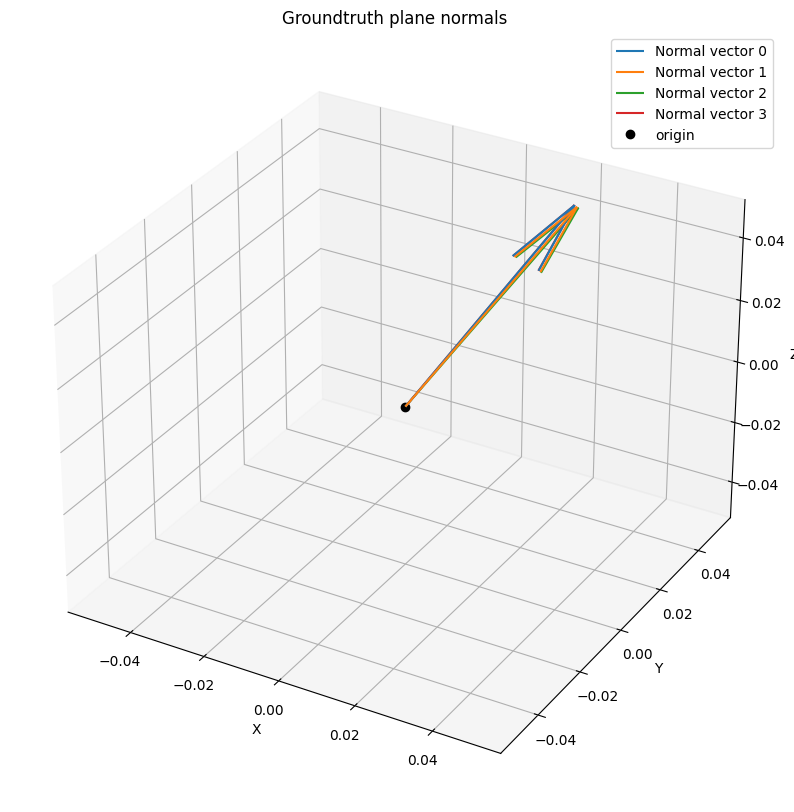

In [125]:
# Let's visualize the normal vectors (from angles to 3D vectors)
normals = angles_to_normal_vector(plane_angle)
plot_3d_scatter(point_cloud=None, vects=normals/15., title="Groundtruth plane normals")

In [126]:
# Let's sample the azimuth coordinates and compute the altitude of the planes
azimuth_coordinates_phi, altitude_z = create_planes_projection(plane_angle)
p3D_gt = angle_to_3d_vector(azimuth_coordinates_phi, altitude_z=altitude_z) # [N, L, 3]


# PART 2: Fitting planes from vector data

## Sampling the planes
- Let's sample the azimuth coordinates and compute the altitude of the planes.
- We can visualize the groundtruth planes:
  - as a collection of 3D points
  - after projecting into the borehole 2D space (a curve in the image)
- It is also possible to visualize the plane tangents in 3D (use the Jacobian of `image_vector_to_3d_plane_tangent` and multiply by the 2D gradients).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


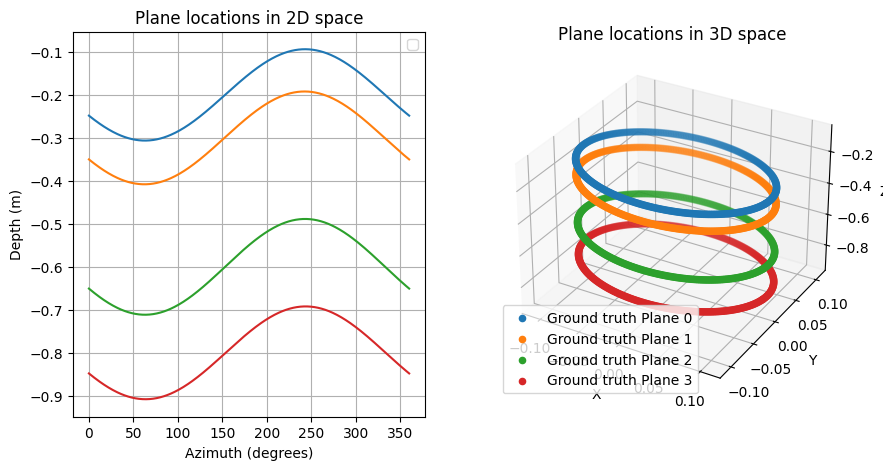

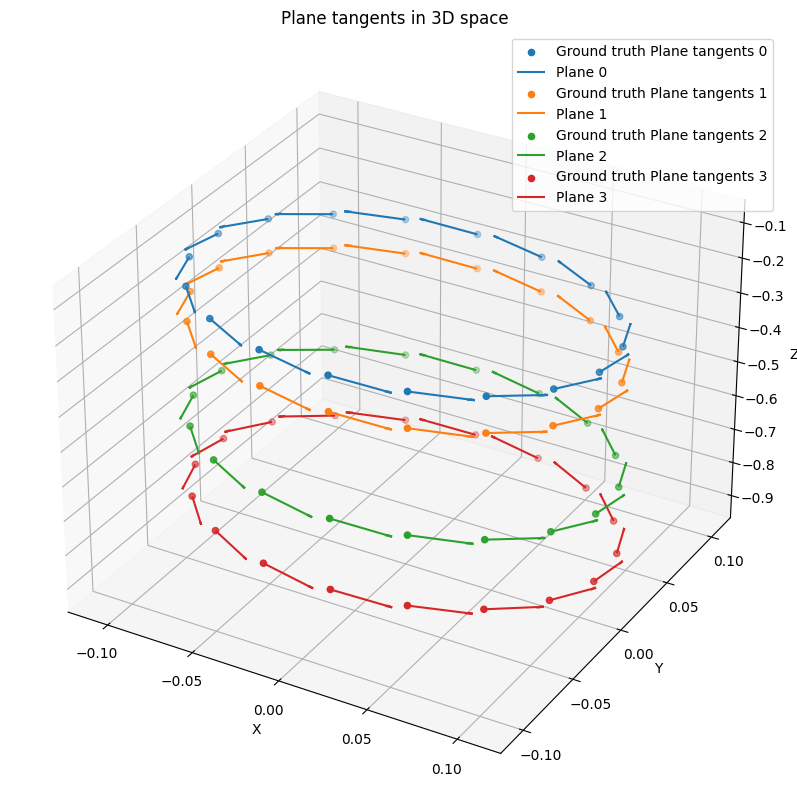

In [127]:
# We can visualize the groundtruth planes after projecting into the borehole 2D space.
plot_ground_truth_3d(
    azimuth_coordinates_phi,
    altitude_z,
    p3D_gt
)

In [128]:
groundtruth_grad_list_3d = get_3d_tangent_estimation_using_groundtruth(azimuth_coordinates_phi, altitude_z)

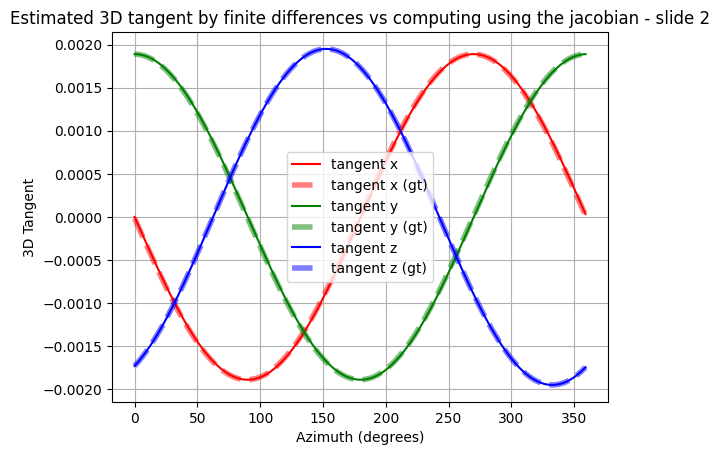

In [129]:
# The following code is used for visual validation and could be moved to a pytest.
# Computation of the tangent vectors using the jacobian of `image_vector_to_3d_plane_tangent`
# Not normalized!
validation_of_3d_tangent_estimation(
    azimuth_coordinates_phi,
    groundtruth_grad_list_3d,
    p3D_gt=p3D_gt,
    batches_index=[2]
)
# Finite difference gradient or using the jacobian seems to be consistent!

## Concept validation
- Use the groundtruth planes (knowledge on dip dip $\delta$ , azimuth $\alpha$).
- Sample projected points
- Take the tangents, perform randomized cross products, decompose into (dip $\hat{\delta}$ , azimuth $\hat{\alpha}$) angles
### 🔍 Method 1: Randomized cross products

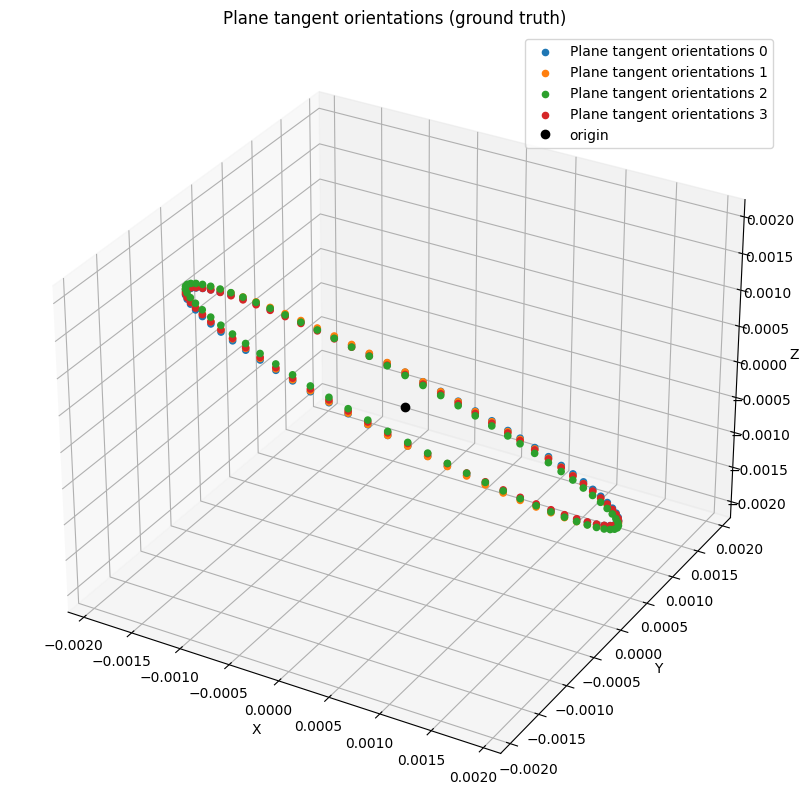

In [130]:
plot_3d_scatter(
    groundtruth_grad_list_3d[:, ::5, :],
    label="Plane tangent orientations",
    title="Plane tangent orientations (ground truth)"
)

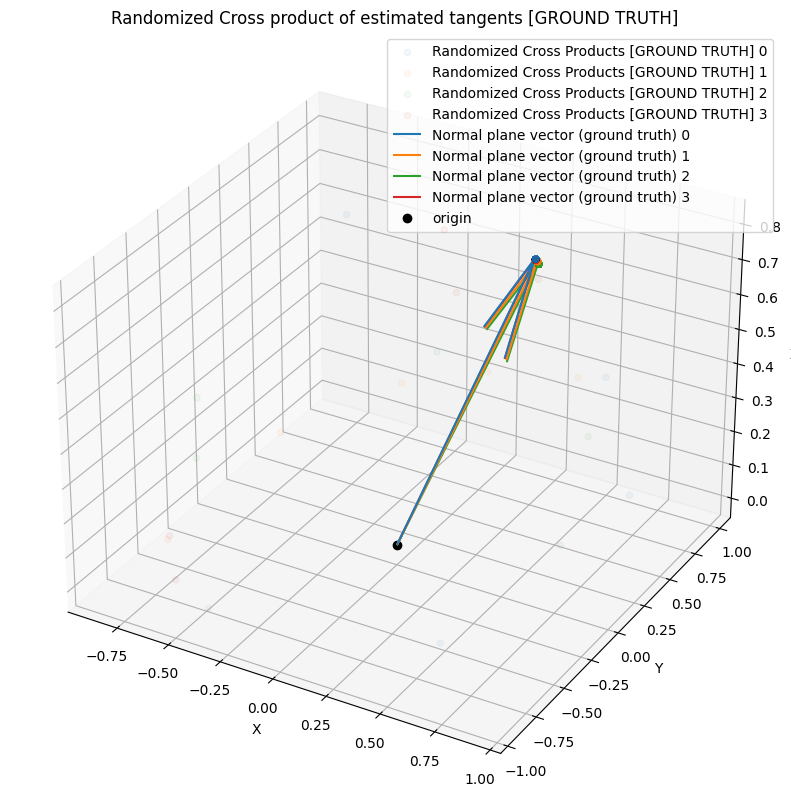

In [131]:
cross_product_gt, cross_product_norm_gt = get_cross_products(groundtruth_grad_list_3d, num_points=1000)
plot_3d_scatter(
    cross_product_gt,
    vects=normals,
    alpha=0.05,
    # colors="tab:cyan",
    label="Randomized Cross Products [GROUND TRUTH]",
    label_vector="Normal plane vector (ground truth)",
    title="Randomized Cross product of estimated tangents [GROUND TRUTH]"
)


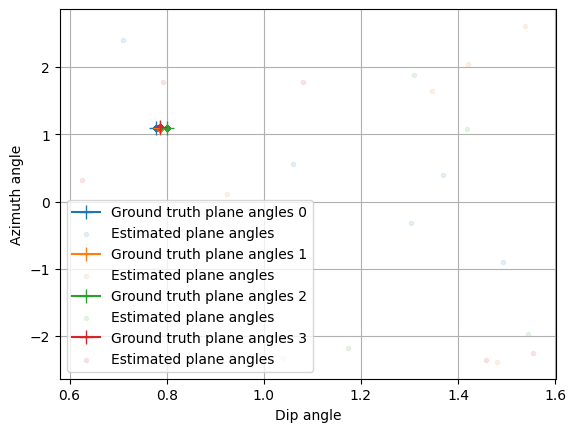

In [134]:
# Scatter plot of the ground truth plane angles and the estimated plane angles
# this  sanity check shows a good agreement between the ground truth and the estimated plane angles.
dip_az_gt = normal_vector_to_angles(cross_product_gt)
for batch_idx in range(dip_az_gt.shape[0]):
    color = COLORS[batch_idx%len(COLORS)]
    plt.plot(plane_angle[batch_idx, 0], plane_angle[batch_idx, 1], marker="+",  color=color, markersize=10, label=f"Ground truth plane angles {batch_idx}")
    plt.scatter(dip_az_gt[batch_idx, :, 0], dip_az_gt[batch_idx, :, 1], color=color, marker=".", alpha=0.1, label=f"Estimated plane angles")
plt.grid()
plt.xlabel("Dip angle")
plt.ylabel("Azimuth angle")
plt.legend()
plt.show()


### 🔍 Method 2: Minimization method

$\forall 1 \leq i \leq N$, $\vec{a_{i}}$ are the 3D unitary vectors estimating the tangents, orthogonal to the plane unit normal that we're trying to estimate $\vec{n}$.

We should have $\vec{a_{i}}^T \vec{n} \approx 0$ which can be reformulated as a minimization:

Find $\vec{n}$ which minimizes $\sum_{i=1}^{N}\vec{a_{i}}^T \vec{n}$ under the constraint $\vec{n}^{T}\vec{n} = 1$.

If the constraint was not here, we could write this as a simple linear system  $A.\vec{n}=\vec{0_{N}}$ where:
- $A$ is a $(N, 3)$ matrix.
- $\vec{n}$ is a (3, 1) vector
- but the solution would be the trivial $\vec{0}_{3}$. 

Let's compute the norm of this $\vec{0_{N}}$ to rewrite this as a quadratic cost $\vec{n}^{T}A^TA\vec{n}$ which we want  to minimize.
- $A^TA$ is a $(3,3)$ matrix


Relaxing the constraint on the vector unit norm, we can write down the optimization as :
$$\text{min}_{\vec{n}} (\vec{n}^{T}A^TA\vec{n} + \lambda  (\vec{n}^{T}\vec{n} - 1) )$$
After setting the gradient of this cost to zero, we obtain $A^T.A \vec{n} = - \lambda \vec{n}$ which means that we're looking for the eigenvector of matrix $A^T.A$ .

In [151]:
groundtruth_grad_list_3d.shape

torch.Size([4, 359, 3])

-------


# PART 3: Working with images
- 1/ Synthesize a borehole image with planar sections (and a bit of noise) from the known groundtruth orientations.
- 2/ Detect and select areas of relevant gradients. Extract a list of 2D gradient vectors (and tengeants) and their corresponding 2D locations.
- 3/ Project these 2D locations onto the 3D cylinder, find the 3D tangents.
- 4/ Extract the plane normals by randomly sampling the 3D tangent vectors and computing the cross products
- 5/ Extract the dip and azimuth angles by building the 2D histogram and extracting the most likely mode.

### 3.1 - Simulate the borehole image

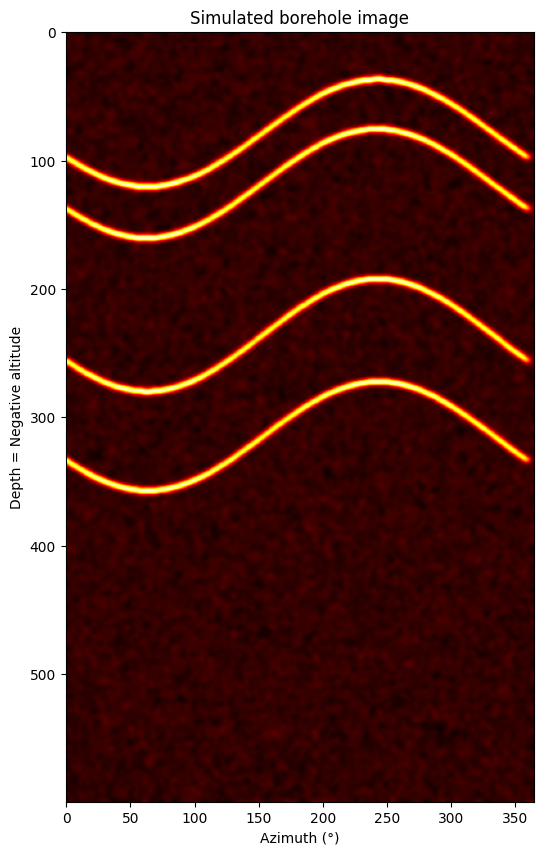

In [135]:
# 1 - Simulate the borehole image
img = simulated_splat_image(azimuth_coordinates_phi, altitude_z)
show_borehole_image(img)

### 3.2 - Extract 2D gradients

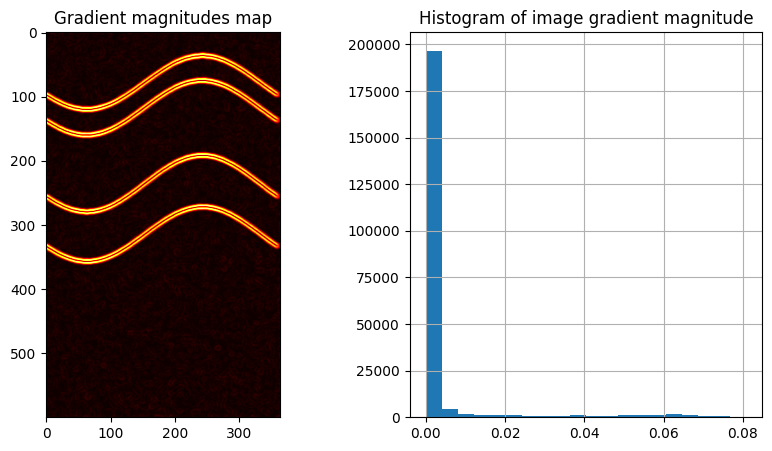

In [136]:
# 2 - Extract 2D gradients from the image add thresholding to remove noise.
img_grad = filters.sobel(img)
show_gradients_magnitudes(img_grad)

In [137]:
img_grad_h, img_grad_v, img_grad, coords = extract_2d_gradients_from_image(img)

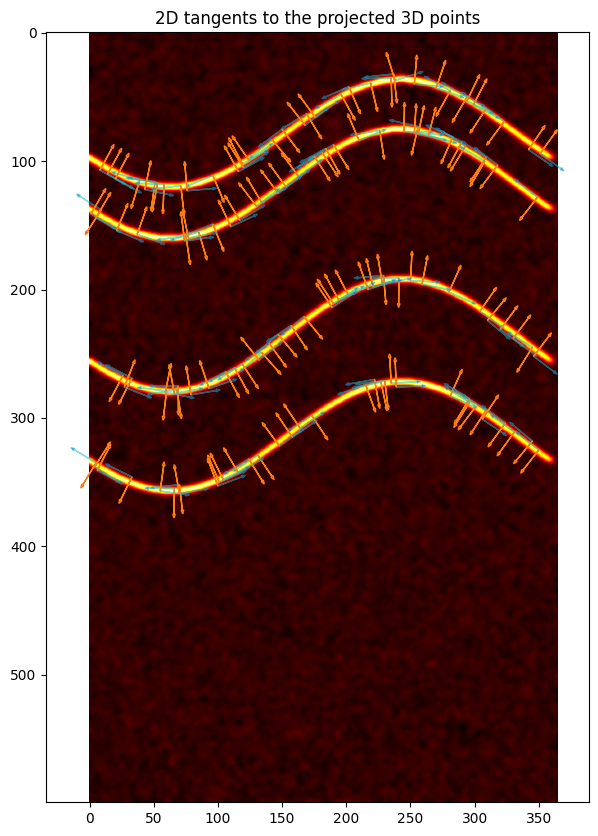

In [138]:
plot_tangents_and_gradients_field(coords, img_grad_h, img_grad_v, img)

### 3.3 From 2D gradients to 3D tangents

In [139]:
# Compute the correctly scaled tangent vectors (in SI units, angles in radians, altitudes in meters)
tan_vec_2d = get_tangent_vec_from_gradients(img_grad_h, img_grad_v, normalize=False)

In [140]:
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)

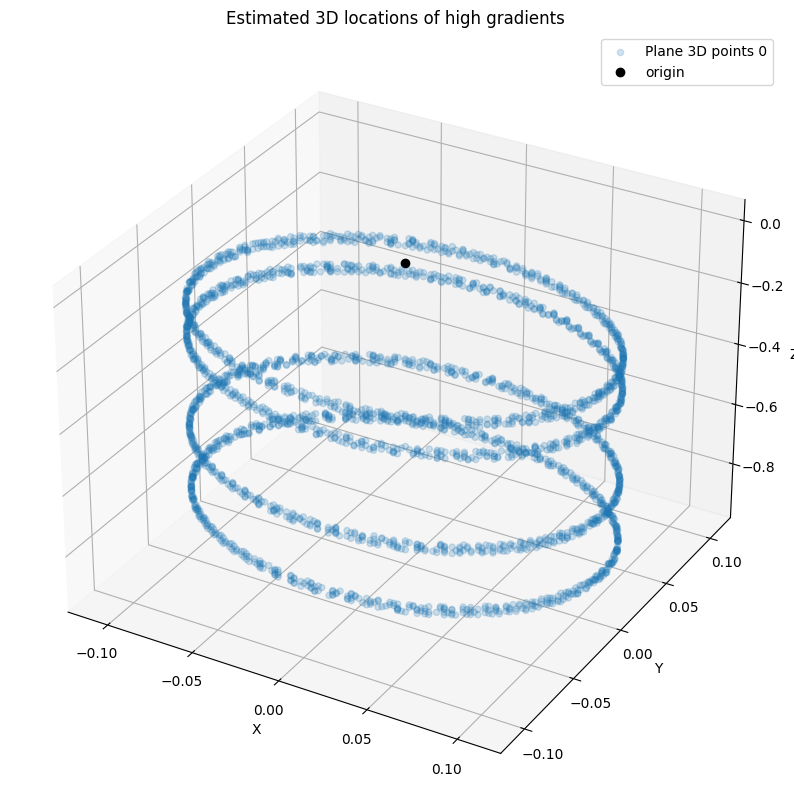

In [141]:
# We also have the locations of the high gradients 2D points... they lie on the planes as one would expect.
# We don't know though which plane they belong to now!
plot_3d_scatter(p3D_est[:, ::5], title="Estimated 3D locations of high gradients", alpha=0.2)

In [142]:
# Compute the 3D tangent vectors (and normalize)
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)

azi_list = torch.deg2rad(img_coords[:, 1]).unsqueeze(0)
alt_list = -img_coords[:, 0]*DEPTH_STEP
tangent = np.array([
    -img_grad_v, # y 
    img_grad_h,
]).T
tangent.shape
tangents_3d = []
for idx in range(azi_list.shape[1]):
    azi = azi_list[0, idx]
    alt = alt_list[idx]
    delta_azi = tan_vec_2d[idx, 0]
    delta_alt = tan_vec_2d[idx, 1]
    tan3d = image_vector_to_3d_plane_tangent(azi, alt, delta_azi, delta_alt)
    tan3d = tan3d / tan3d.norm() # normalize the 3D tangent
    tangents_3d.append(tan3d)
tangents_3d = torch.stack(tangents_3d, dim=0).unsqueeze(0)

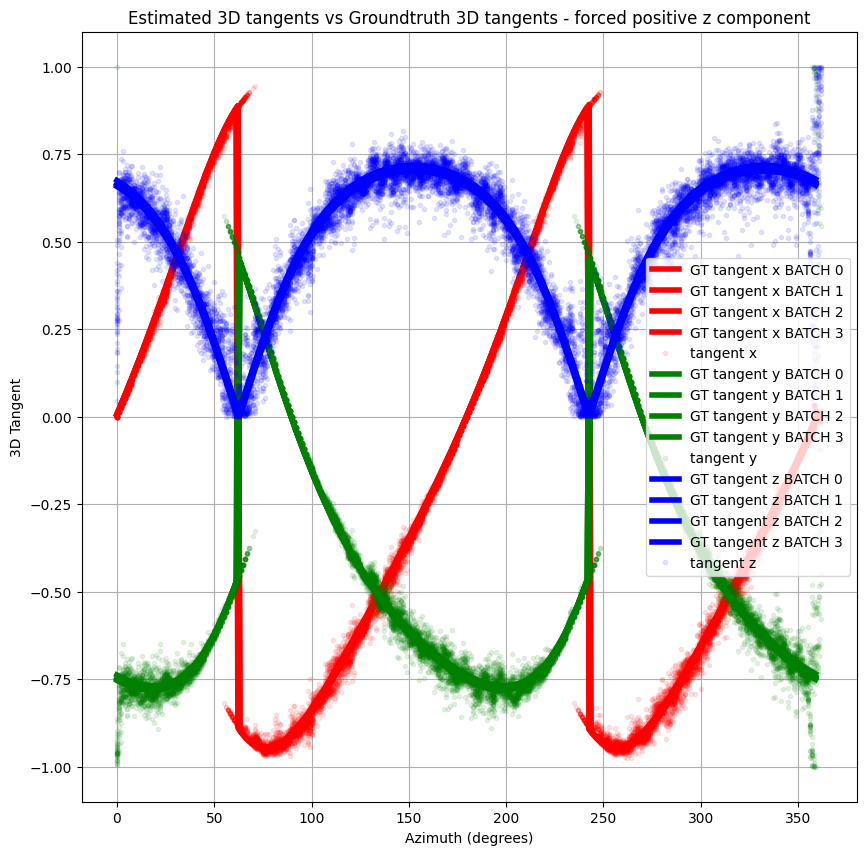

In [143]:
# Sanity check of the 3D tangent estimation
tangent3d = (p3D_gt[..., 1:, :] - p3D_gt[..., :-1, :])
tangent3d = tangent3d / tangent3d.norm(dim=-1, keepdim=True)
plt.figure(figsize=(10, 10))
for dim_idx, dim_name, dim_color  in zip(range(3), "xyz", "rgb"): 
    for batch_idx in range(azimuth_coordinates_phi.shape[0]):
        plt.plot(
            torch.rad2deg(azimuth_coordinates_phi[batch_idx, :-1]),
            tangent3d[batch_idx,  :, dim_idx]*torch.sign(tangent3d[batch_idx,  :, -1]),
            "-",
            color=dim_color,
            linewidth=4, alpha=1.,
            label=f"GT tangent {dim_name} BATCH {batch_idx}"
        )
    for batch_idx in range(azi_list.shape[0]):
        plt.plot(
            torch.rad2deg(azi_list[batch_idx]),
            (-tangents_3d[batch_idx, :, dim_idx])*torch.sign(-tangents_3d[batch_idx, :, -1]),
            "."+dim_color, label=f"tangent {dim_name}", alpha=0.1)
plt.xlabel("Azimuth (degrees)")
plt.ylabel("3D Tangent")
plt.legend()
plt.grid()
plt.title("Estimated 3D tangents vs Groundtruth 3D tangents - forced positive z component")
plt.show()

### 3.4 Extract the plane normals by randomly sampling the 3D tangent vectors and computing the cross products

In [144]:
cross_product_estimated, cross_product_norm_estim = get_cross_products(tangents_3d, num_points=10000)

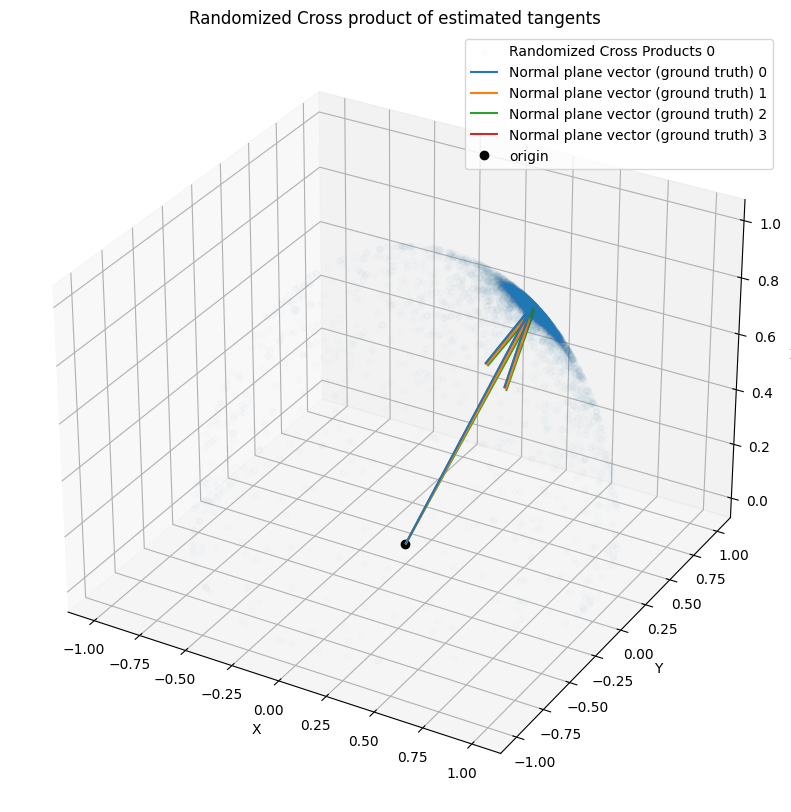

In [145]:
plot_3d_scatter(
    point_cloud=cross_product_estimated,
    # sizes=cross_product_norm_estim,
    # vectors = normals,
    vects=normals,
    alpha=0.01,
    # fixed="tab:cyan",
    label="Randomized Cross Products",
    label_vector="Normal plane vector (ground truth)",
    title="Randomized Cross product of estimated tangents")

We can clearly see the massive aggregation of points near the plane normal groundtruths (the arrows).
Computing a 3D histogram will be more costly so let's switch to dip, azimuth 2D coordinates so we can simplify the computations and find the right plane parameters. 

### 3.5 Extract the dip and azimuth angles by building the 2D histogram and extracting the most likely mode.

In [146]:
dip_az_estim = normal_vector_to_angles(cross_product_estimated)

In [147]:
histo, bin_edges  = torch.histogramdd(dip_az_estim.squeeze(0), bins = [100, 100])
maxi = torch.max(histo)
amax_mode = torch.where(histo == maxi)
# Calculate the midpoint of the bins for plotting
x_mid = (bin_edges[1][amax_mode[1]+1] + bin_edges[1][amax_mode[1]]) / 2.0
y_mid = (bin_edges[0][amax_mode[0]+1] + bin_edges[0][amax_mode[0]]) / 2.0

best_dip = y_mid[0]
best_azimuth = x_mid[0]
print(f"Estimated dip: {np.rad2deg(best_dip):.3f}° and azimuth: {np.rad2deg(best_azimuth):.3f}°")
print(f"Groundtruth: Dip {np.rad2deg(plane_angle[0, 0]):.3f}° and azimuth: {np.rad2deg(plane_angle[0, 1]):.3f}°")

Estimated dip: 44.742° and azimuth: 62.174°
Groundtruth: Dip 44.550° and azimuth: 63.000°


The above estimation match with the groundtruth, this validating the method which works directly on (simulated) images (*very close to the real borehole images applications, at least much closer than the estimations from vector data from part 2*).

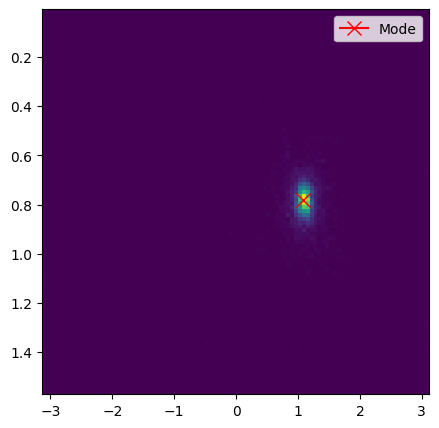

In [148]:
plt.figure(figsize=(5, 5))
plt.imshow(
    histo,
    extent=[
        bin_edges[1][0], bin_edges[1][-1],
        bin_edges[0][-1], bin_edges[0][0],
    ],
    aspect='auto')

# Corrected plot command
plt.plot(
    x_mid,
    y_mid,
    marker="x", color="red", markersize=10, label="Mode")

plt.title(f'')
plt.legend()
plt.show()


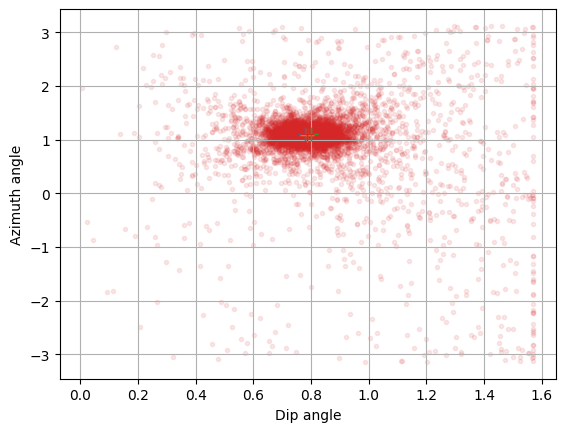

In [150]:
dip_az_estim = normal_vector_to_angles(cross_product_estimated)
for batch_idx in range(plane_angle.shape[0]):
    color = COLORS[batch_idx%len(COLORS)]
    plt.plot(plane_angle[batch_idx, 0], plane_angle[batch_idx, 1], marker="+",  color=color, markersize=10, label="Ground truth plane angles")
for batch_idx in range(dip_az_estim.shape[0]):
    plt.scatter(dip_az_estim[batch_idx, :, 0], dip_az_estim[batch_idx, :, 1], color=color, marker=".", alpha=0.1, label="Estimated plane angles")
plt.grid()
plt.xlabel("Dip angle")
plt.ylabel("Azimuth angle")
plt.show()

# PART4: Step by step dip picking on real images

(12001, 360)


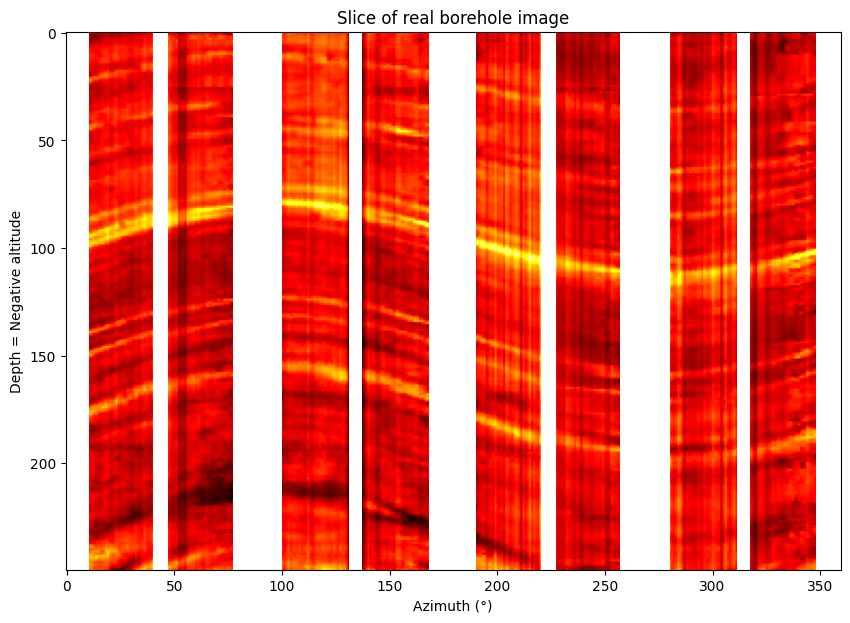

In [103]:
image_input, mask_absent, image_display, tdep = load_data()
roi = image_display[1450:1700]
show_borehole_image(roi, title='Slice of real borehole image')

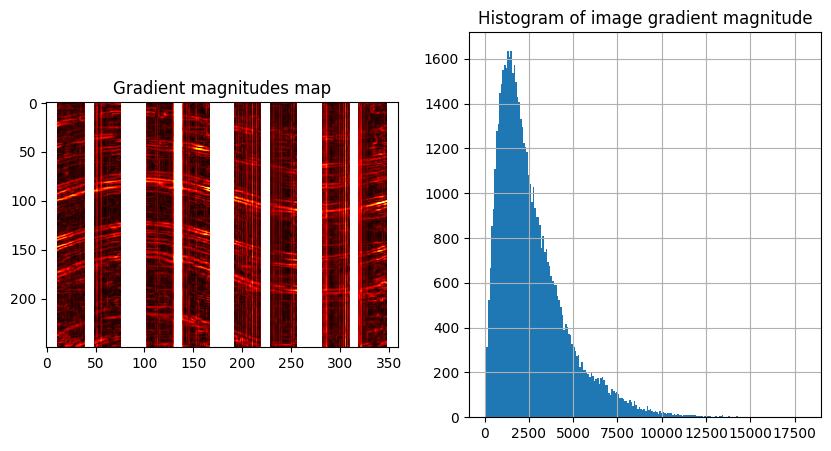

In [104]:
extract_2d_gradients(roi, bins=200)

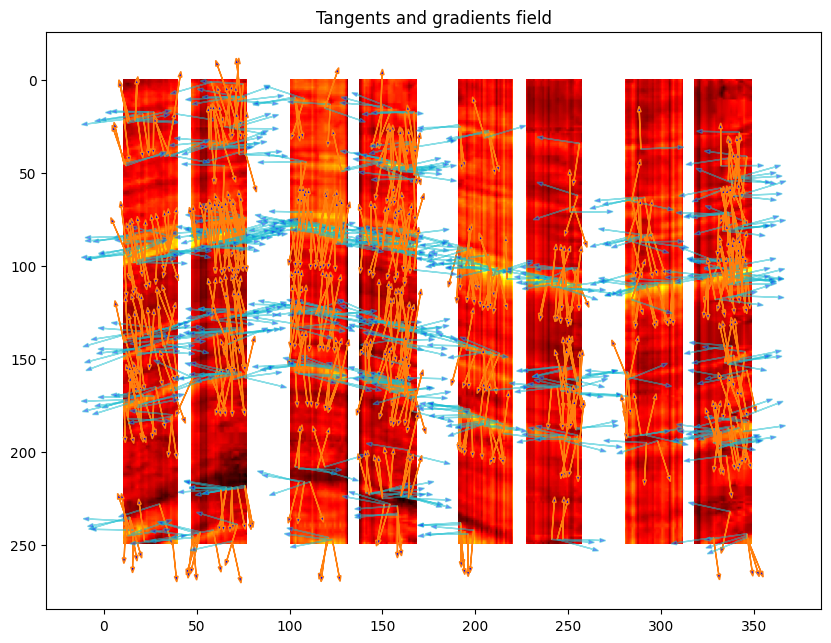

In [108]:
img_grad_h, img_grad_v, img_grad, coords = extract_2d_gradients_from_image(
    roi,
    threshold_magnitude=5000.,
    thresold_abs_v_grad=3000
)
plot_tangents_and_gradients_field(coords, img_grad_h, img_grad_v, roi, decimation=3, title='Tangents and gradients field')

In [109]:
# Compute the correctly scaled tangent vectors (in SI units, angles in radians, altitudes in meters)
tan_vec_2d = get_tangent_vec_from_gradients(img_grad_h, img_grad_v, normalize=False)
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)


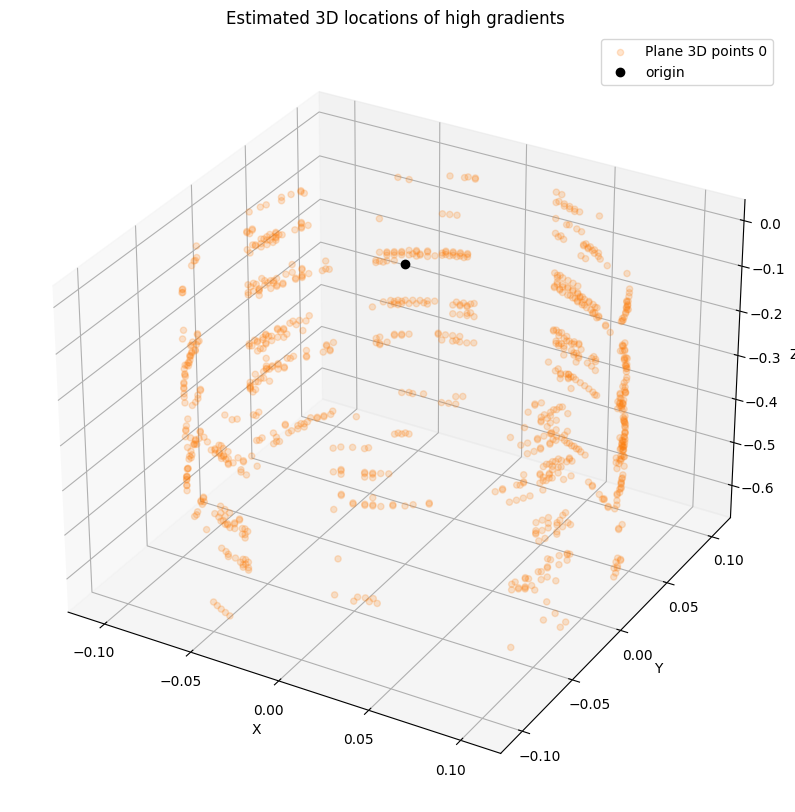

In [110]:
plot_3d_scatter(p3D_est[:, ::2], title="Estimated 3D locations of high gradients", forced_color="tab:orange", alpha=0.2)

In [111]:
# Compute the 3D tangent vectors (and normalize)
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)

azi_list = torch.deg2rad(img_coords[:, 1]).unsqueeze(0)
alt_list = -img_coords[:, 0]*DEPTH_STEP
tangent = np.array([
    -img_grad_v, # y 
    img_grad_h,
]).T
tangent.shape
tangents_3d = []
for idx in range(azi_list.shape[1]):
    azi = azi_list[0, idx]
    alt = alt_list[idx]
    delta_azi = tan_vec_2d[idx, 0]
    delta_alt = tan_vec_2d[idx, 1]
    tan3d = image_vector_to_3d_plane_tangent(azi, alt, delta_azi, delta_alt)
    tan3d = tan3d / tan3d.norm() # normalize the 3D tangent
    tangents_3d.append(tan3d)
tangents_3d = torch.stack(tangents_3d, dim=0).unsqueeze(0)


In [112]:
cross_product_estimated, cross_product_norm_estim = get_cross_products(tangents_3d, num_points=50000)

In [113]:
dip_az_estim = normal_vector_to_angles(cross_product_estimated)

In [114]:
histo, bin_edges  = torch.histogramdd(dip_az_estim, bins = [20, 20])
maxi = torch.max(histo)
print(maxi)
amax_mode = torch.where(histo == maxi)
print(amax_mode)
# Calculate the midpoint of the bins for plotting
x_mid = (bin_edges[1][amax_mode[1]+1] + bin_edges[1][amax_mode[1]]) / 2.0
y_mid = (bin_edges[0][amax_mode[0]+1] + bin_edges[0][amax_mode[0]]) / 2.0

best_dip = y_mid[0]
best_azimuth = x_mid[0]
print(f"Estimated dip: {np.rad2deg(best_dip):.3f}° and azimuth: {np.rad2deg(best_azimuth):.3f}°")

tensor(770.)
(tensor([4]), tensor([4]))
Estimated dip: 20.378° and azimuth: -99.002°


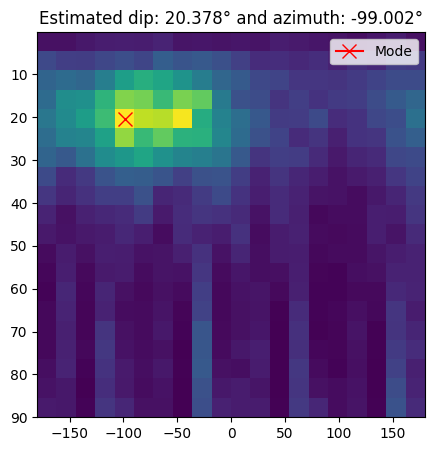

In [115]:
plt.figure(figsize=(5, 5))
plt.imshow(
    histo,
    extent=[
        np.rad2deg(bin_edges[1][0]), np.rad2deg(bin_edges[1][-1]),
        np.rad2deg(bin_edges[0][-1]), np.rad2deg(bin_edges[0][0]),
    ],
    aspect='auto')
plt.plot(
    np.rad2deg(x_mid),
    np.rad2deg(y_mid),
    marker="x", color="red", markersize=10, label="Mode")
plt.title(f"Estimated dip: {np.rad2deg(best_dip):.3f}° and azimuth: {np.rad2deg(best_azimuth):.3f}°")
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


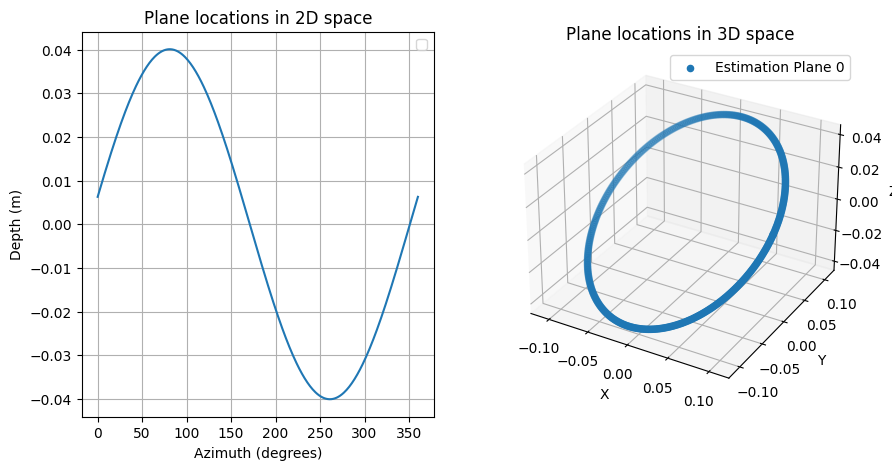

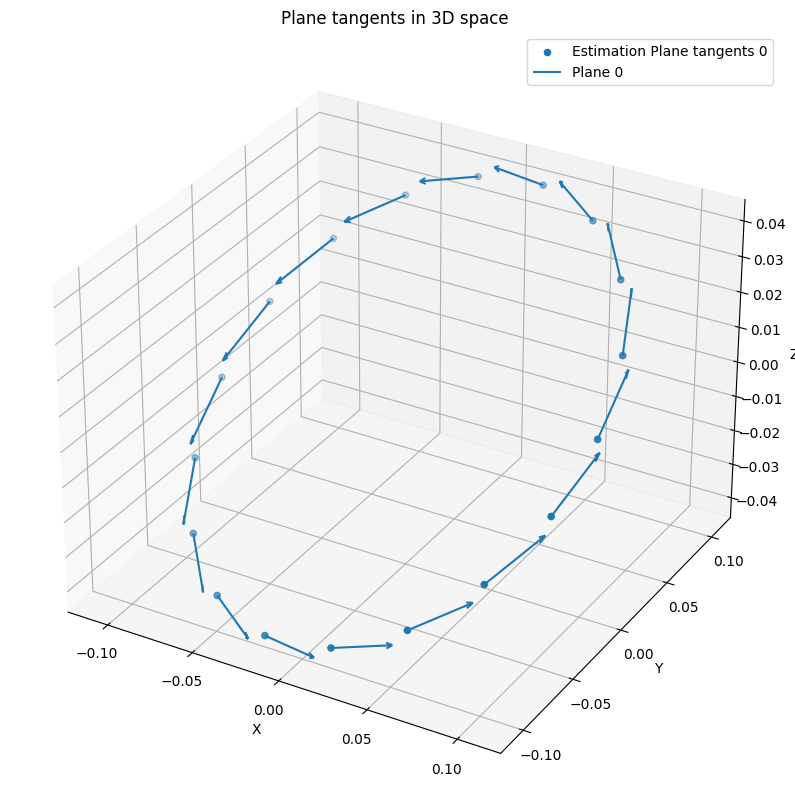

In [116]:
estimated_plane_angle = torch.tensor(
    [
        [best_dip, best_azimuth, 0.],
    ]
)
# Let's visualize the normal vectors (from angles to 3D vectors)
estimated_normals = angles_to_normal_vector(estimated_plane_angle)
# plot_3d_scatter(point_cloud=None, vects=estimated_normals/15., title="Estimated plane normals")
# Let's sample the azimuth coordinates and compute the altitude of the planes
azimuth_coordinates_phi, altitude_z = create_planes_projection(estimated_plane_angle)
p3D_est = angle_to_3d_vector(azimuth_coordinates_phi, altitude_z=altitude_z) # [N, L, 3]

plot_ground_truth_3d(
    azimuth_coordinates_phi,
    altitude_z,
    p3D_est,
    name= "Estimation"
)

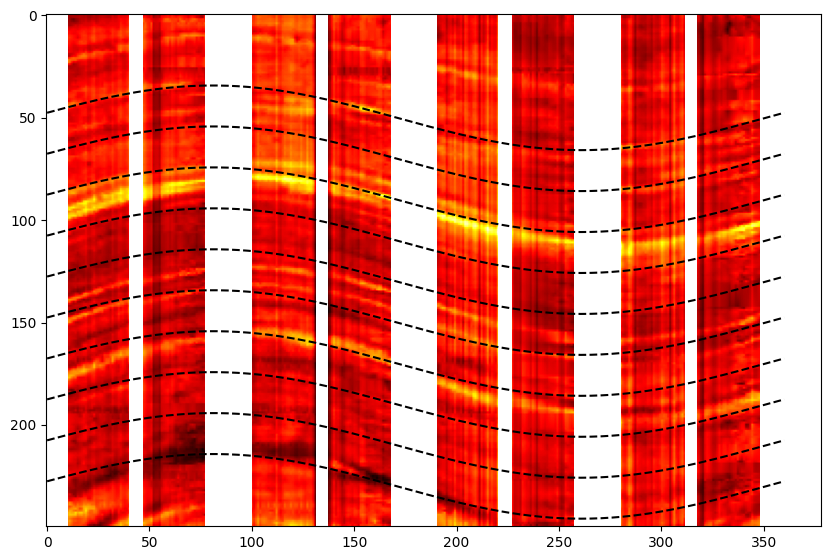

In [119]:
plt.figure(figsize=(10, 10))
plt.imshow(roi, cmap='hot')
for offset in range(50, 250, 20):
    plt.plot(np.rad2deg(azimuth_coordinates_phi).T, offset-altitude_z.T/DEPTH_STEP, 'k--')
# plt.plot(np.rad2deg(azimuth_coordinates_phi).T, -500-altitude_z.T/DEPTH_STEP, 'g-')
plt.show()

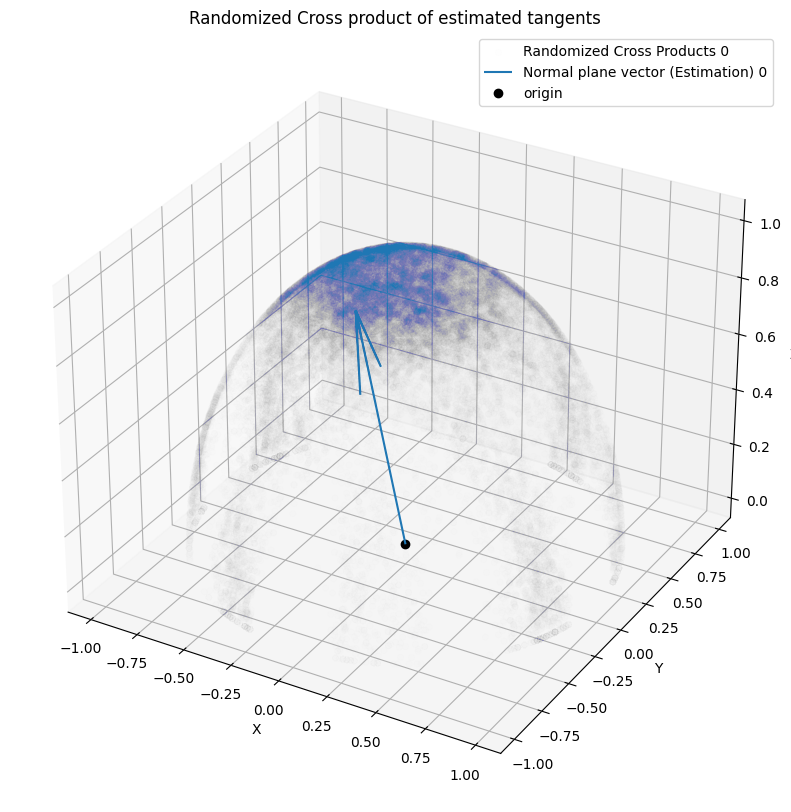

In [118]:
plot_3d_scatter(
    point_cloud=cross_product_estimated,
    alpha=0.002,
    # fixed="tab:cyan",
    vects=estimated_normals,
    label="Randomized Cross Products",
    label_vector="Normal plane vector (Estimation)",
    title="Randomized Cross product of estimated tangents")